Better suited GANs for image data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


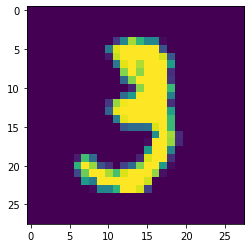

In [7]:
plt.imshow(X_train[10])

In [8]:
X_train.min()

0

In [13]:
X_train = X_train/255
X_train = X_train.reshape(-1, 28, 28, 1) * 2. -1.

In [16]:
X_train.min()
# tanh used thus made values to be -1 to 1 range

-1.0

In [17]:
X_train.max()

1.0

In [18]:
zeros = X_train[y_train==0]

In [19]:
zeros.shape

(5923, 28, 28, 1)

In [21]:
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import  Sequential

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

coding_size = 100

In [24]:
7*7*128

6272

In [25]:
generator = Sequential()
generator.add(Dense(7*7*128, input_shape=[coding_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))

In [26]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [27]:
GAN = Sequential([generator, discriminator])

In [28]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [29]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [32]:
GAN.layers[1].layers

In [40]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
________________________________________________

In [41]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

In [42]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [43]:
batch_size = 32

In [46]:
data = zeros

In [48]:
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000)

In [49]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [50]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [51]:
epochs = 20

In [53]:
generator, discriminator = GAN.layers
for epoch in range(epochs):
  print(f"On epoch {epoch+1}")
  i = 0
  for X_batch in dataset:
    i = i+1
    if i%20 == 0:
      print(f"\t Batch number {i} of {len(data//batch_size)}")
    
    # TRAIN DISCRIMINATOR
    noise = tf.random.normal(shape=[batch_size, coding_size])

    # Generate Numbers on NOISE
    gen_images = generator(noise)

    # Concat generated ones with Fake
    X_real_vs_fake = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)

    # Y set 0 for fake, 1 for real imgs
    y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
    discriminator.trainable = True

    discriminator.train_on_batch(X_real_vs_fake, y1)


    # TRAIN GENERATOR
    noise = tf.random.normal(shape=[batch_size, coding_size])
    # Discriminator are made to believe generated images are real 1.0
    y2 = tf.constant([[1.0]]*batch_size)

    discriminator.trainable = False

    GAN.train_on_batch(noise, y2)

On epoch 1
	 Batch number 20 of 5923
	 Batch number 40 of 5923
	 Batch number 60 of 5923
	 Batch number 80 of 5923
	 Batch number 100 of 5923
	 Batch number 120 of 5923
	 Batch number 140 of 5923
	 Batch number 160 of 5923
	 Batch number 180 of 5923
On epoch 2
	 Batch number 20 of 5923
	 Batch number 40 of 5923
	 Batch number 60 of 5923
	 Batch number 80 of 5923
	 Batch number 100 of 5923
	 Batch number 120 of 5923
	 Batch number 140 of 5923
	 Batch number 160 of 5923
	 Batch number 180 of 5923
On epoch 3
	 Batch number 20 of 5923
	 Batch number 40 of 5923
	 Batch number 60 of 5923
	 Batch number 80 of 5923
	 Batch number 100 of 5923
	 Batch number 120 of 5923
	 Batch number 140 of 5923
	 Batch number 160 of 5923
	 Batch number 180 of 5923
On epoch 4
	 Batch number 20 of 5923
	 Batch number 40 of 5923
	 Batch number 60 of 5923
	 Batch number 80 of 5923
	 Batch number 100 of 5923
	 Batch number 120 of 5923
	 Batch number 140 of 5923
	 Batch number 160 of 5923
	 Batch number 180 of 5923


In [54]:
noise = tf.random.normal(shape=[10, coding_size])
noise.shape

TensorShape([10, 100])

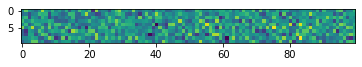

In [55]:
plt.imshow(noise)

In [59]:
images = generator(noise)

In [60]:
an_image = images[0]

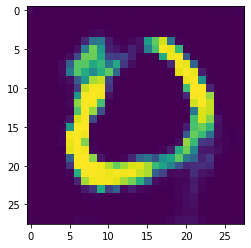

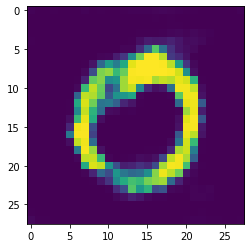

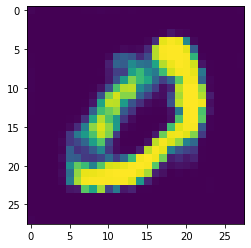

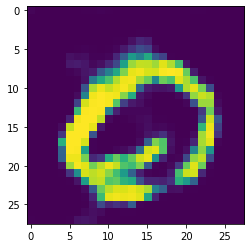

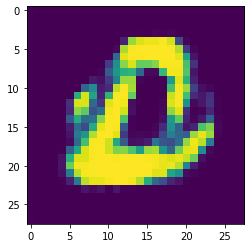

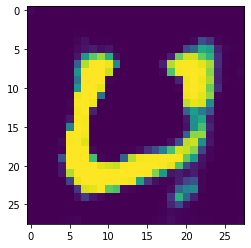

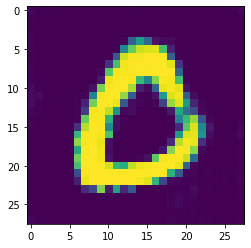

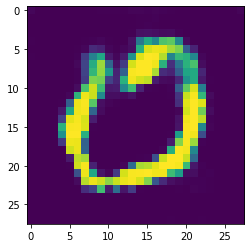

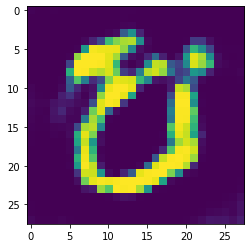

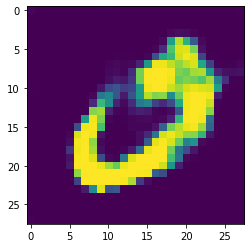

In [61]:
for image in images:
  plt.imshow(image.numpy().reshape(28, 28))
  plt.show()

# Model Collapse happens ? Diversity?